## 예제 12-1. Theta 모델 예시

### 개인 소비 지출 데이터

#### 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.forecasting.theta import ThetaModel

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [5]:
# FRED 데이터에서 PCE 데이터 가져오기
reader = pdr.fred.FredReader(["NA000349Q"], start="1959-01-01", end="2024-10-01")
pce = reader.read()

# 컬럼명 변경 및 주기 설정
pce.columns = ["PCE"]
pce.index.freq = "QS"

pce

,PCE
DATE,
1959-01-01,74391
1959-04-01,79197
1959-07-01,78707
1959-10-01,84835
1960-01-01,78095
...,...
2023-10-01,4901064
2024-01-01,4739457
2024-04-01,4944799


### 데이터 시각화

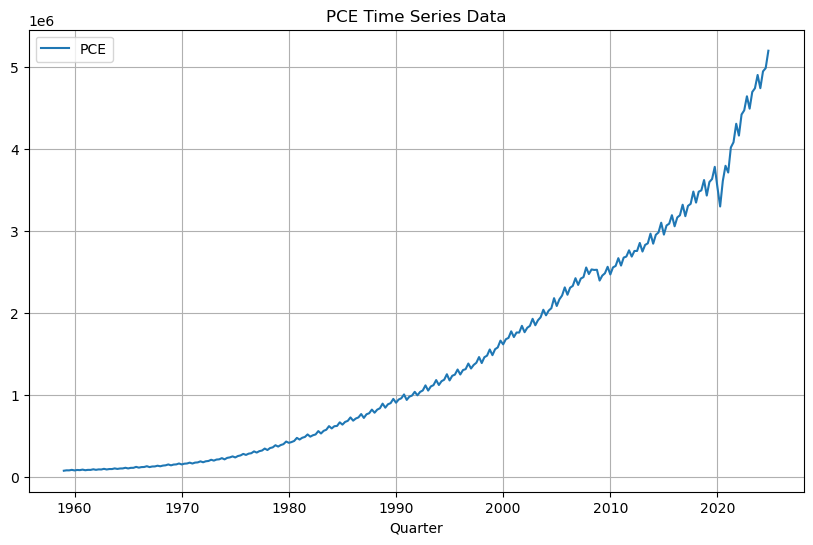

In [7]:
# 그래프 및 스타일 설정
plt.figure(figsize=(10, 6))
plt.plot(pce, label="PCE")
plt.grid(True)
plt.legend()
plt.xlabel("Quarter")
plt.title("PCE Time Series Data")
plt.show()

#### Theta 모델 적합

In [8]:
# Theta 모델 적용 (로그 변환 후 모델 학습)
mod = ThetaModel(np.log(pce))
res = mod.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                    PCE   No. Observations:                  264
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Wed, 26 Feb 2025   Deseas. Method:         Multiplicative
Time:                        20:26:11   Period:                              4
Sample:                    01-01-1959                                         
                         - 10-01-2024                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    0.01632705940938158
alpha  0.9998314056474347
-------------------------


#### 모델 예측

In [9]:
# 예측 수행 및 데이터 저장
forecasts = pd.DataFrame(
    {
        "ln PCE": np.log(pce.PCE),  # 로그 변환된 PCE 데이터
        "theta=1.2": res.forecast(12, theta=1.2),  # theta=1.2로 예측
        "theta=2": res.forecast(12),  # 기본 theta=2로 예측
        "theta=3": res.forecast(12, theta=3),  # theta=3으로 예측
        "No damping": res.forecast(12, theta=np.inf),  # 감쇠 없이 예측
    }
)

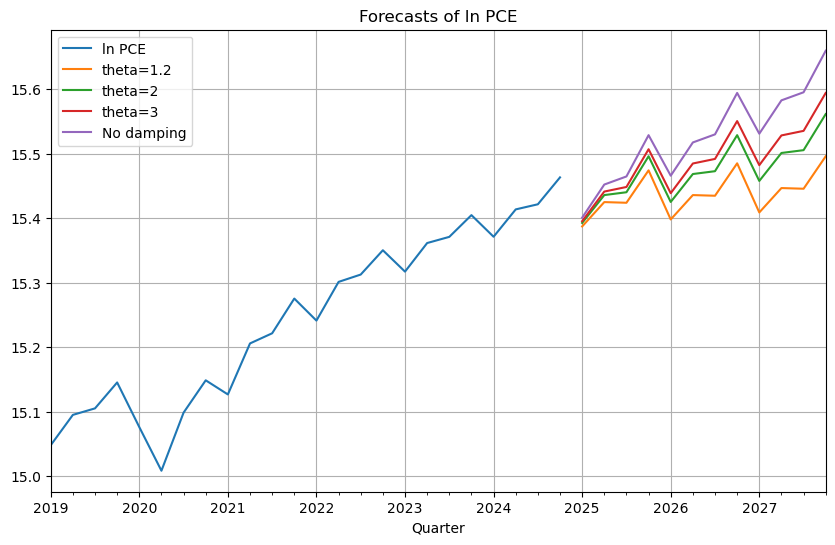

In [15]:
# 예측 데이터 시각화
_ = forecasts.tail(36).plot(figsize=(10, 6))
plt.title("Forecasts of ln PCE")
plt.xlabel("Quarter")
plt.grid(True)
plt.show()

In [16]:
# 과거 데이터를 기반으로 여러 해에 걸친 예측 수행
ln_pce = np.log(pce.PCE)
forecasts = {"ln PCE": ln_pce}
for year in range(1975, 2025, 3):  # 1975년부터 3년 간격으로 예측 수행
    sub = ln_pce[: str(year)]
    res = ThetaModel(sub).fit()
    fcast = res.forecast(12)
    forecasts[str(year)] = fcast

# 예측 결과를 데이터프레임으로 변환
forecasts = pd.DataFrame(forecasts)

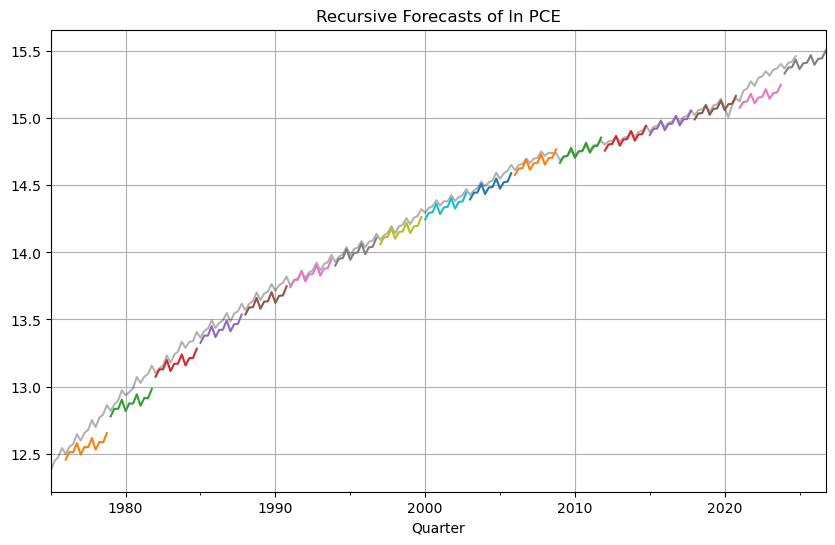

In [21]:
# 1975년 이후 예측 결과 시각화
ax = forecasts["1975":].plot(legend=False, figsize=(10, 6))
children = ax.get_children()
children[0].set_alpha(0.3)  # 투명도 조정
children[0].set_color("#000000")  # 색상 변경 (검정)
ax.set_title("Recursive Forecasts of ln PCE")
plt.grid(True)
plt.xlabel("Quarter")
plt.show()

## 예제 12-2. TBATS 모델 예시

### 위키백과 페이지 조회수 데이터

#### 필요한 패키지 불러오기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tbats import TBATS 

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [25]:
# 데이터 로드
# Prophet 예제 데이터 불러오기
data = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
data['ds'] = pd.to_datetime(data['ds'])
data.set_index('ds', inplace=True)

In [26]:
# 원본 데이터는 일별 데이터가 아닐 수도 있으므로, 일별 주기로 리샘플링
# 누락된 값이 있을 경우 보간을 통해 채울 수 있음
data = data.resample('D').asfreq()
data.index.freq = 'D'  # 일별 주기로 설정

#### TBATS 모델 적합

In [28]:
# TBATS 모델 초기화 (연간 계절성을 고려하여 설정)
estimator = TBATS(seasonal_periods=[365.25]) 

# 모델 학습 전에 NaN 값을 제거해야 함
data = data.dropna(subset=['y'])  

# TBATS 모델 학습
model_tbats = estimator.fit(data['y'])

#### 모델 예측

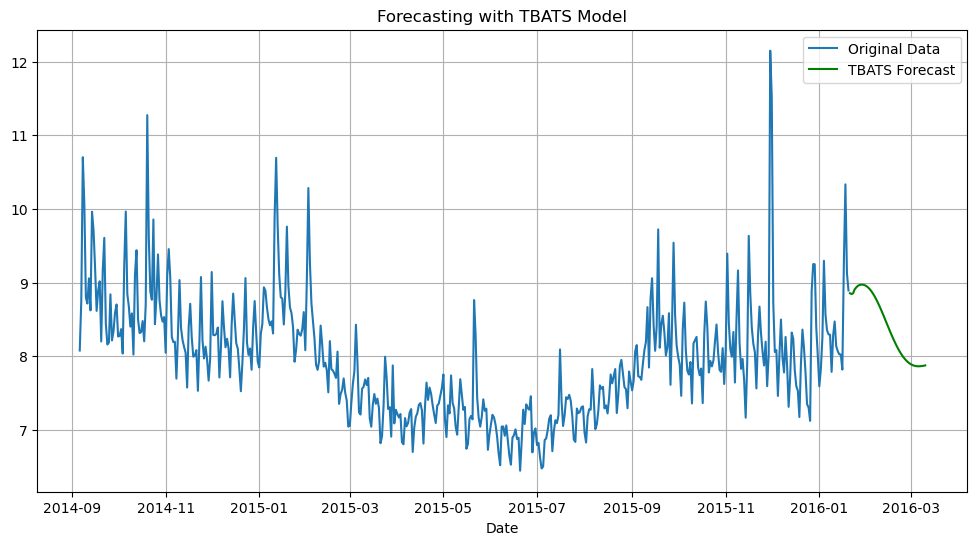

In [29]:
# 30일 예측 수행
forecast_tbats = model_tbats.forecast(steps=50)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['y'][-500:], label='Original Data')
plt.plot(pd.date_range(data.index[-1], periods=51, freq='D')[1:], forecast_tbats, label='TBATS Forecast', color='green')
plt.title('Forecasting with TBATS Model')
plt.grid(True)
plt.xlabel("Date")
plt.legend()
plt.show()